# Earthdata Cloud Access and PACE Demo

Based on the PACE Hackweek Tutorial started by Anna Windle and Continued by Patrick Gray

An [Earthdata Login][edl] account is required to access data from the NASA Earthdata system, including NASA ocean color data.

</div>

[edl]: https://urs.earthdata.nasa.gov/

## 1. Setup

We begin by importing the packages used in this notebook.

This will also install a few packages in case you're working in colab.

In [ ]:
pip install earthaccess

In [ ]:
pip install cartopy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 44.5 MB/s eta 0:00:00


In [ ]:
pip install cmocean

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 421.9/421.9 kB 5.6 MB/s eta 0:00:00


In [ ]:
import earthaccess
import xarray as xr
from xarray.backends.api import open_datatree
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
from matplotlib.colors import LogNorm
import cmocean

The last import provides a preview of the `DataTree` object. Once it is fully integrated into XArray,
the additional import won't be needed, as the function will be available as `xr.open_datree`.

[back to top](#Contents)

## 2. NASA Earthdata Authentication

Next, we authenticate using our Earthdata Login
credentials. Authentication is not needed to search publicaly
available collections in Earthdata, but is always needed to access
data. We can use the `login` method from the `earthaccess`
package. This will create an authenticated session when we provide a
valid Earthdata Login username and password. The `earthaccess`
package will search for credentials defined by **environmental
variables** or within a **.netrc** file saved in the home
directory. If credentials are not found, an interactive prompt will
allow you to input credentials.

<div class="alert alert-info" role="alert">
    
The `persist=True` argument ensures any discovered credentials are
stored in a `.netrc` file, so the argument is not necessary (but
it's also harmless) for subsequent calls to `earthaccess.login`.

</div>

In [ ]:
auth = earthaccess.login(persist=True)

[back to top](#Contents)

## 3. Search for Data

Collections on NASA Earthdata are discovered with the
`search_datasets` function, which accepts an `instrument` filter as an
easy way to get started. Each of the items in the list of
collections returned has a "short-name".

In [ ]:
results = earthaccess.search_datasets(instrument="oci")

In [ ]:
for item in results:
    summary = item.summary()
    print(summary["short-name"])

PACE_OCI_L1B_SCI
PACE_OCI_L0_SCI
PACE_OCI_L1A_SCI
PACE_OCI_L1C_SCI
PACE_OCI_L2_AOP
PACE_OCI_L2_AOP_NRT
PACE_OCI_L2_BGC
PACE_OCI_L2_BGC_NRT
PACE_OCI_L2_CLOUD
PACE_OCI_L2_CLOUD_MASK
PACE_OCI_L2_CLOUD_MASK_NRT
PACE_OCI_L2_CLOUD_NRT
PACE_OCI_L2_IOP
PACE_OCI_L2_IOP_NRT
PACE_OCI_L2_LANDVI
PACE_OCI_L2_LANDVI_NRT
PACE_OCI_L2_PAR
PACE_OCI_L2_PAR_NRT
PACE_OCI_L2_SFREFL
PACE_OCI_L2_SFREFL_NRT
PACE_OCI_L3B_AVW
PACE_OCI_L3B_AVW_NRT
PACE_OCI_L3B_CARBON
PACE_OCI_L3B_CARBON_NRT
PACE_OCI_L3B_CHL
PACE_OCI_L3B_CHL_NRT
PACE_OCI_L3B_FLH
PACE_OCI_L3B_FLH_NRT
PACE_OCI_L3B_IOP
PACE_OCI_L3B_IOP_NRT
PACE_OCI_L3B_KD
PACE_OCI_L3B_KD_NRT
PACE_OCI_L3B_LANDVI
PACE_OCI_L3B_LANDVI_NRT
PACE_OCI_L3B_PAR
PACE_OCI_L3B_PAR_NRT
PACE_OCI_L3B_POC
PACE_OCI_L3B_POC_NRT
PACE_OCI_L3B_RRS
PACE_OCI_L3B_RRS_NRT
PACE_OCI_L3B_SFREFL
PACE_OCI_L3B_SFREFL_NRT
PACE_OCI_L3M_AVW
PACE_OCI_L3M_AVW_NRT
PACE_OCI_L3M_CARBON
PACE_OCI_L3M_CARBON_NRT
PACE_OCI_L3M_CHL
PACE_OCI_L3M_CHL_NRT
PACE_OCI_L3M_CLOUD
PACE_OCI_L3M_CLOUD_NRT
PACE_OCI_L3M_FLH
PA

<div class="alert alert-info" role="alert">
The short name can also be found on <a href="https://search.earthdata.nasa.gov/search?fi=SPEXone!HARP2!OCI" target="_blank"> Eartdata Search</a>, directly under the collection name, after clicking on the "i" button for a collection in any search result.
</div>

Next, we use the `search_data` function to find granules within a
collection. Let's use the `short_name` for the PACE/OCI Level-2 near real time (NRT), product for biogeochemical properties (although you can
search for granules accross collections too).



The `count` argument limits the number of granules whose metadata is returned and stored in the `results` list.

In [ ]:
results = earthaccess.search_data(
    short_name="PACE_OCI_L3B_CHL_NRT",
    count=1,
)

In [ ]:
results[0]

Collection: {'Version': '3.0', 'ShortName': 'PACE_OCI_L3B_CHL_NRT'}
Spatial coverage: {'HorizontalSpatialDomain': {'Geometry': {'BoundingRectangles': [{'EastBoundingCoordinate': 180, 'WestBoundingCoordinate': -180, 'SouthBoundingCoordinate': -90, 'NorthBoundingCoordinate': 90}]}}}
Temporal coverage: {'RangeDateTime': {'BeginningDateTime': '2025-01-01T00:00:00Z', 'EndingDateTime': '2025-01-01T23:59:59Z'}}
Size(MB): 26.985539436340332
Data: ['https://obdaac-tea.earthdatacloud.nasa.gov/ob-cumulus-prod-public/PACE_OCI.20250101.L3b.DAY.CHL.V3_0.NRT.nc']

We can refine our search by passing more parameters that describe
the spatiotemporal domain of our use case. Here, we use the
`temporal` parameter to request a date range and the `bounding_box`
parameter to request granules that intersect with a bounding box. We
can even provide a `cloud_cover` threshold to limit files that have
a lower percetnage of cloud cover. We do not provide a `count`, so
we'll get all granules that satisfy the constraints.

In [ ]:
tspan = ("2025-03-01", "2025-05-30")
bbox = (-72, 41, -65, 48)
clouds = (0, 60)

In [ ]:
results = earthaccess.search_data(
    short_name="PACE_OCI_L3B_CHL_NRT",
    temporal=tspan,
    bounding_box=bbox,
    cloud_cover=clouds,
)

In [ ]:
len(results)

0

In [ ]:
results[0]

IndexError: list index out of range

In [ ]:
results[1]

IndexError: list index out of range

In [ ]:
results[2]

Collection: {'Version': '3.0', 'ShortName': 'PACE_OCI_L2_BGC_NRT'}
Spatial coverage: {'HorizontalSpatialDomain': {'Geometry': {'GPolygons': [{'Boundary': {'Points': [{'Latitude': 43.69763, 'Longitude': -64.36122}, {'Latitude': 37.89394, 'Longitude': -95.79886}, {'Latitude': 20.60254, 'Longitude': -88.45814}, {'Latitude': 25.86642, 'Longitude': -62.6541}, {'Latitude': 43.69763, 'Longitude': -64.36122}]}}]}}}
Temporal coverage: {'RangeDateTime': {'EndingDateTime': '2025-03-19T17:53:15Z', 'BeginningDateTime': '2025-03-19T17:48:16Z'}}
Size(MB): 18.75511360168457
Data: ['https://obdaac-tea.earthdatacloud.nasa.gov/ob-cumulus-prod-public/PACE_OCI.20250319T174816.L2.OC_BGC.V3_0.NRT.nc']

In [ ]:
results[3]

Collection: {'Version': '3.0', 'ShortName': 'PACE_OCI_L2_BGC_NRT'}
Spatial coverage: {'HorizontalSpatialDomain': {'Geometry': {'GPolygons': [{'Boundary': {'Points': [{'Latitude': 44.55553, 'Longitude': -57.49873}, {'Latitude': 38.70847, 'Longitude': -89.35603}, {'Latitude': 21.45982, 'Longitude': -81.83822}, {'Latitude': 26.74, 'Longitude': -55.85658}, {'Latitude': 44.55553, 'Longitude': -57.49873}]}}]}}}
Temporal coverage: {'RangeDateTime': {'BeginningDateTime': '2025-03-21T17:20:53Z', 'EndingDateTime': '2025-03-21T17:25:52Z'}}
Size(MB): 19.24907684326172
Data: ['https://obdaac-tea.earthdatacloud.nasa.gov/ob-cumulus-prod-public/PACE_OCI.20250321T172053.L2.OC_BGC.V3_0.NRT.nc']

[back to top](#Contents)

## 4. Open L2 Data

Let's go ahead and open a couple granules using `xarray`. The `earthaccess.open` function is used when you want to directly read bytes from a remote filesystem, but not download a whole file. When
running code on a host with direct access to the NASA Earthdata
Cloud, you don't need to download the data and `earthaccess.open`
is the way to go.

In [ ]:
paths = earthaccess.open(results)

QUEUEING TASKS | :   0%|          | 0/24 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/24 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/24 [00:00<?, ?it/s]

The `paths` list contains references to files on a remote filesystem. The ob-cumulus-prod-public is the S3 Bucket in AWS us-west-2 region.

In [ ]:
dataset = xr.open_dataset(paths[2])
dataset

<xarray.Dataset> Size: 0B
Dimensions:  ()
Data variables:
    *empty*
Attributes: (12/45)
    title:                             OCI Level-2 Data BGC
    product_name:                      PACE_OCI.20250319T174816.L2.OC_BGC.V3_...
    processing_version:                3.0
    history:                           l2gen par=/data10/sdpsoper/vdc/vpu29/w...
    instrument:                        OCI
    platform:                          PACE
    ...                                ...
    geospatial_lon_max:                -62.6541
    geospatial_lon_min:                -95.79886
    startDirection:                    Ascending
    endDirection:                      Ascending
    day_night_flag:                    Day
    earth_sun_distance_correction:     1.0086592435836792

Notice that this `xarray.Dataset` has nothing but "Attributes". The NetCDF data model includes multi-group hierarchies within a single file, where each group maps to an `xarray.Dataset`. The whole file maps to a `DataTree`, which we will only use lightly because the implementation in XArray remains under development.

In [ ]:
datatree = open_datatree(paths[2])
datatree

<ipython-input-20-77ad5ee3bbe5>:1: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  datatree = open_datatree(paths[2])


<xarray.DataTree>
Group: /
│   Attributes: (12/45)
│       title:                             OCI Level-2 Data BGC
│       product_name:                      PACE_OCI.20250319T174816.L2.OC_BGC.V3_...
│       processing_version:                3.0
│       history:                           l2gen par=/data10/sdpsoper/vdc/vpu29/w...
│       instrument:                        OCI
│       platform:                          PACE
│       ...                                ...
│       geospatial_lon_max:                -62.6541
│       geospatial_lon_min:                -95.79886
│       startDirection:                    Ascending
│       endDirection:                      Ascending
│       day_night_flag:                    Day
│       earth_sun_distance_correction:     1.0086592435836792
├── Group: /sensor_band_parameters
│       Dimensions:      (number_of_bands: 286, number_of_reflective_bands: 286)
│       Dimensions without coordinates: number_of_bands, number_of_reflective_bands
│       Data variables:
│           wavelength   (number_of_bands) float64 2kB ...
│           vcal_gain    (number_of_reflective_bands) float32 1kB ...
│           vcal_offset  (number_of_reflective_bands) float32 1kB ...
│           F0           (number_of_reflective_bands) float32 1kB ...
│           aw           (number_of_reflective_bands) float32 1kB ...
│           bbw          (number_of_reflective_bands) float32 1kB ...
│           k_oz         (number_of_reflective_bands) float32 1kB ...
│           k_no2        (number_of_reflective_bands) float32 1kB ...
│           Tau_r        (number_of_reflective_bands) float32 1kB ...
├── Group: /scan_line_attributes
│       Dimensions:  (number_of_lines: 1710)
│       Dimensions without coordinates: number_of_lines
│       Data variables: (12/13)
│           year     (number_of_lines) float64 14kB ...
│           day      (number_of_lines) timedelta64[ns] 14kB ...
│           msec     (number_of_lines) timedelta64[ns] 14kB ...
│           time     (number_of_lines) datetime64[ns] 14kB ...
│           detnum   (number_of_lines) float32 7kB ...
│           mside    (number_of_lines) float32 7kB ...
│           ...       ...
│           clon     (number_of_lines) float32 7kB ...
│           elon     (number_of_lines) float32 7kB ...
│           slat     (number_of_lines) float32 7kB ...
│           clat     (number_of_lines) float32 7kB ...
│           elat     (number_of_lines) float32 7kB ...
│           csol_z   (number_of_lines) float32 7kB ...
├── Group: /geophysical_data
│       Dimensions:           (number_of_lines: 1710, pixels_per_line: 1272)
│       Dimensions without coordinates: number_of_lines, pixels_per_line
│       Data variables:
│           chlor_a           (number_of_lines, pixels_per_line) float32 9MB ...
│           carbon_phyto      (number_of_lines, pixels_per_line) float32 9MB ...
│           poc               (number_of_lines, pixels_per_line) float32 9MB ...
│           chlor_a_unc       (number_of_lines, pixels_per_line) float32 9MB ...
│           carbon_phyto_unc  (number_of_lines, pixels_per_line) float32 9MB ...
│           l2_flags          (number_of_lines, pixels_per_line) int32 9MB ...
├── Group: /navigation_data
│       Dimensions:    (number_of_lines: 1710, pixels_per_line: 1272)
│       Dimensions without coordinates: number_of_lines, pixels_per_line
│       Data variables:
│           longitude  (number_of_lines, pixels_per_line) float32 9MB ...
│           latitude   (number_of_lines, pixels_per_line) float32 9MB ...
│           tilt       (number_of_lines) float32 7kB ...
│       Attributes:
│           gringpointlongitude:  [-88.45814 -62.6541  -64.36122 -95.79886]
│           gringpointlatitude:   [20.602541 25.86642  43.69763  37.893944]
│           gringpointsequence:   [1 2 3 4]
└── Group: /processing_control
    │   Attributes:
    │       software_name:     l2gen
    │       software_version:  9.11.0-V2025.1
    │       input_sources:     PACE_OCI.2025031

In [ ]:
dataset = xr.merge(datatree.to_dict().values())
dataset

<xarray.Dataset> Size: 70MB
Dimensions:           (number_of_bands: 286, number_of_reflective_bands: 286,
                       number_of_lines: 1710, pixels_per_line: 1272)
Dimensions without coordinates: number_of_bands, number_of_reflective_bands,
                                number_of_lines, pixels_per_line
Data variables: (12/31)
    wavelength        (number_of_bands) float64 2kB ...
    vcal_gain         (number_of_reflective_bands) float32 1kB ...
    vcal_offset       (number_of_reflective_bands) float32 1kB ...
    F0                (number_of_reflective_bands) float32 1kB ...
    aw                (number_of_reflective_bands) float32 1kB ...
    bbw               (number_of_reflective_bands) float32 1kB ...
    ...                ...
    chlor_a_unc       (number_of_lines, pixels_per_line) float32 9MB ...
    carbon_phyto_unc  (number_of_lines, pixels_per_line) float32 9MB ...
    l2_flags          (number_of_lines, pixels_per_line) int32 9MB ...
    longitude         (number_of_lines, pixels_per_line) float32 9MB ...
    latitude          (number_of_lines, pixels_per_line) float32 9MB ...
    tilt              (number_of_lines) float32 7kB ...
Attributes: (12/45)
    title:                             OCI Level-2 Data BGC
    product_name:                      PACE_OCI.20250319T174816.L2.OC_BGC.V3_...
    processing_version:                3.0
    history:                           l2gen par=/data10/sdpsoper/vdc/vpu29/w...
    instrument:                        OCI
    platform:                          PACE
    ...                                ...
    geospatial_lon_max:                -62.6541
    geospatial_lon_min:                -95.79886
    startDirection:                    Ascending
    endDirection:                      Ascending
    day_night_flag:                    Day
    earth_sun_distance_correction:     1.0086592435836792

Here let's play with the raw data with lines as the y axis and pixels as the x axis

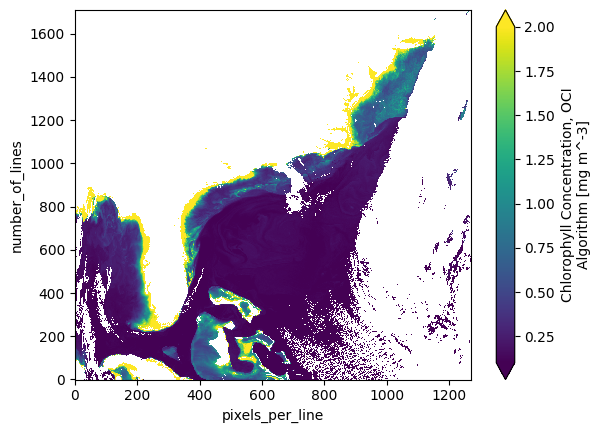

In [ ]:
dataset["chlor_a"].plot(cmap="viridis", vmin=.1, vmax=2)
plt.show()

Let's set the coordinates and plot with latitude and longitude so we can project the data onto a grid.

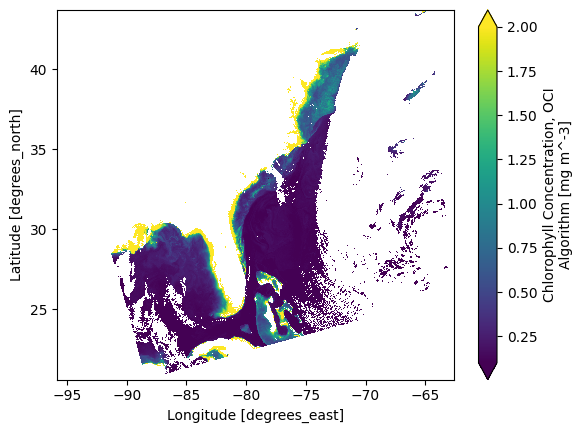

In [ ]:
dataset = dataset.set_coords(("longitude", "latitude"))
dataset["chlor_a"].plot(x="longitude", y="latitude", cmap="viridis", vmin=.1, vmax=2)
plt.show()

And if we want to get fancy, we can add the coastline.

/usr/local/lib/python3.11/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_physical/ne_50m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


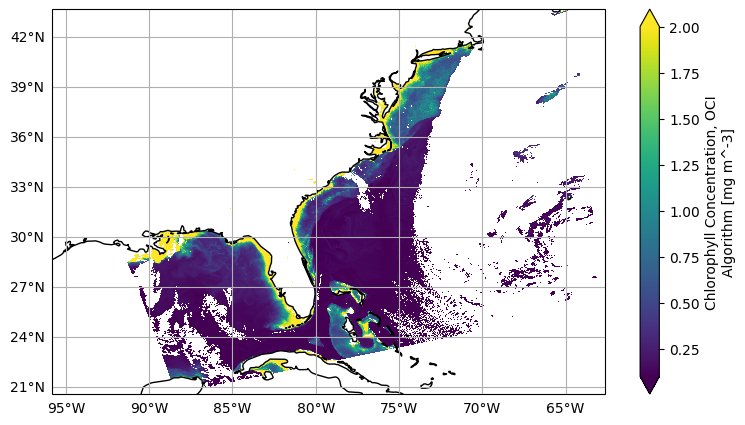

In [ ]:
fig = plt.figure(figsize=(9,5))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines(draw_labels={"left": "y", "bottom": "x"})
dataset["chlor_a"].plot(x="longitude", y="latitude", cmap="viridis", vmin=0.1, vmax=2, ax=ax)

plt.show()

But really chla is typically lognormally distributed to let's use a log normal scale

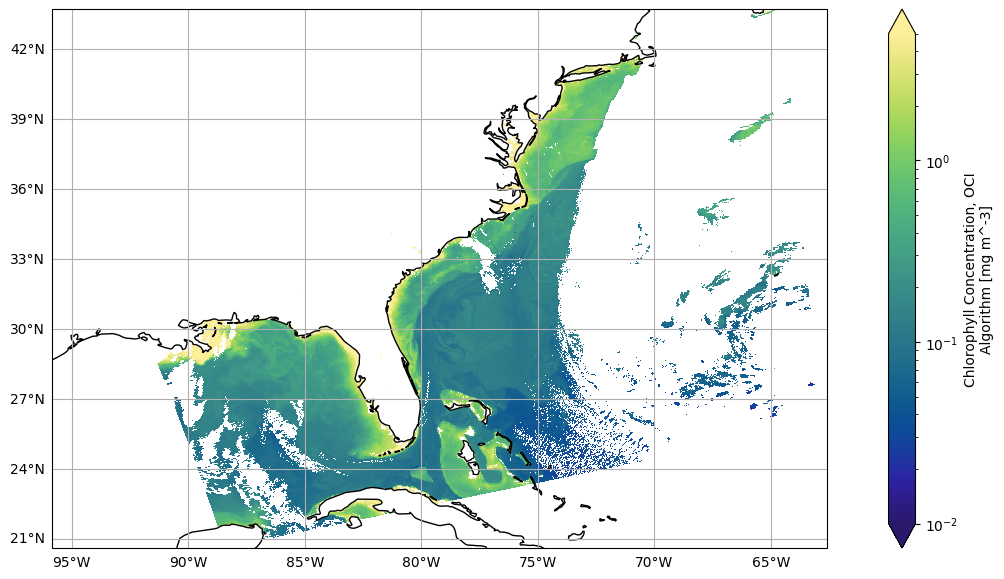

In [ ]:
fig = plt.figure(figsize=(16,7))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines(draw_labels={"left": "y", "bottom": "x"})
plot = dataset["chlor_a"].plot(x="longitude", y="latitude", cmap=cmocean.cm.haline,norm=LogNorm(vmin=.01, vmax=5), ax=ax)

# ax.set_xlim(-66,-50)
# ax.set_ylim(-45,-32)

# plt.savefig('figs/cocco_chla.png',dpi=300,transparent=True)

But some of this data may be suspicious so let's check out the flags. They're available in the data here:

In [ ]:
dataset.l2_flags

And you can inspect all the current flags on https://oceancolor.gsfc.nasa.gov/resources/atbd/ocl2flags/ and they're listed below and put into a python dictionary.

In [ ]:
# List l2 flags, then build them into a dict
l2_flags_list = [
    "ATMFAIL", "LAND", "PRODWARN", "HIGLINT", "HILT", "HISATZEN", "COASTZ",
    "SPARE", "STRAYLIGHT", "CLDICE", "COCCOLITH", "TURBIDW", "HISOLZEN",
    "SPARE", "LOWLW", "CHLFAIL", "NAVWARN", "ABSAER", "SPARE", "MAXAERITER",
    "MODGLINT", "CHLWARN", "ATMWARN", "SPARE", "SEAICE", "NAVFAIL", "FILTER",
    "SPARE", "BOWTIEDEL", "HIPOL", "PRODFAIL", "SPARE"]

L2_FLAGS = {flag: 1 << idx for idx, flag in enumerate(l2_flags_list)}

# Bailey and Werdell 2006 exclusion criteria
EXCLUSION_FLAGS = ["LAND", "HIGLINT", "HILT", "STRAYLIGHT", "CLDICE",
                   "ATMFAIL", "LOWLW", "FILTER", "NAVFAIL", "NAVWARN"]

In [ ]:
  # Calculate the bitwise OR of all flags in EXCLUSION_FLAGS to get a mask
  exclude_mask = sum(L2_FLAGS[flag] for flag in EXCLUSION_FLAGS)

  # Create a boolean mask
  # True means the flag value does not contain any of the EXCLUSION_FLAGS
  valid_mask = np.bitwise_and(dataset.l2_flags, exclude_mask) == 0

In [ ]:
dataset['flag_mask'] = valid_mask

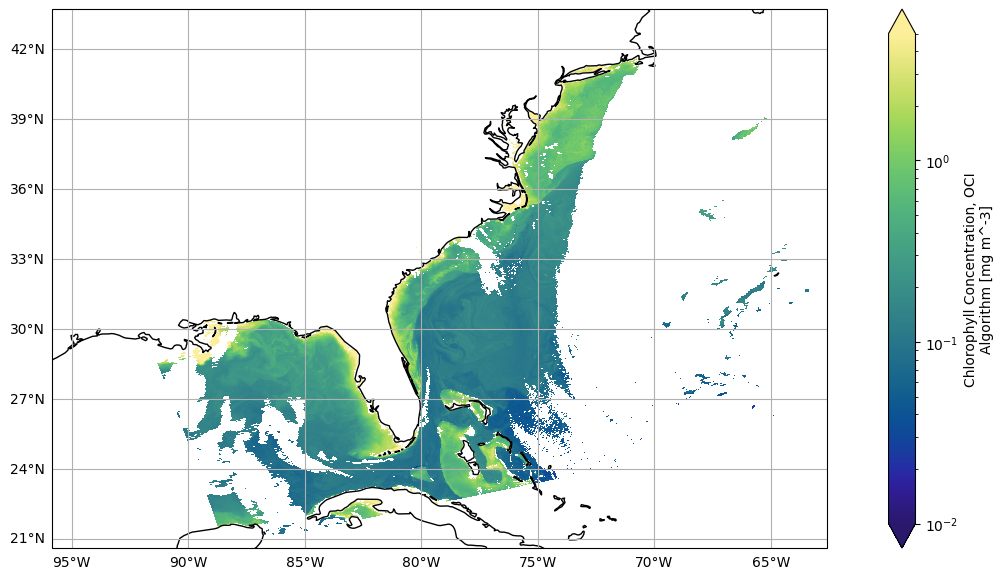

In [ ]:
fig = plt.figure(figsize=(16,7))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines(draw_labels={"left": "y", "bottom": "x"})
plot = dataset["chlor_a"].where(dataset.flag_mask).plot(x="longitude", y="latitude", cmap=cmocean.cm.haline,norm=LogNorm(vmin=.01, vmax=5), ax=ax)

# ax.set_xlim(-66,-50)
# ax.set_ylim(-45,-32)

plt.show()

[back to top](#Contents)

## 5. Open L3M Data

Let's use `earthaccess` to open some L3 mapped chlorophyll a granules. We will use a new search filter available in earthaccess.search_data: the granule_name argument accepts strings with the "*" wildcard. We need this to distinguish daily ("DAY") from eight-day ("8D") composites, as well as to get the 0.1 degree resolution projections.

In [ ]:
tspan = ("2025-04-12", "2025-04-24")

results = earthaccess.search_data(
    short_name="PACE_OCI_L3M_CHL_NRT",
    temporal=tspan,
    granule_name="*.DAY.*.0p1deg.*",
)

paths = earthaccess.open(results)

QUEUEING TASKS | :   0%|          | 0/13 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/13 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/13 [00:00<?, ?it/s]

Let's open the first file using `xarray`.

In [ ]:
dataset = xr.open_dataset(paths[0])
dataset

Becuase the L3M variables have lat and lon coordinates, it's possible to stack multiple granules along a new dimension that corresponds to time. Instead of xr.open_dataset, we use xr.open_mfdataset to create a single xarray.Dataset (the "mf" in open_mfdataset stands for multiple files) from an array of paths.

The paths list is sorted temporally by default, which means the shape of the paths array specifies the way we need to tile the files together into larger arrays. We specify combine="nested" to combine the files according to the shape of the array of files (or file-like objects), even though paths is not a "nested" list in this case. The concat_dim="date" argument generates a new dimension in the combined dataset, because "date" is not an existing dimension in the individual files.

In [ ]:
dataset = xr.open_mfdataset(
    paths,
    combine="nested",
    concat_dim="date",
)
dataset

<xarray.Dataset> Size: 337MB
Dimensions:  (date: 13, lat: 1800, lon: 3600, rgb: 3, eightbitcolor: 256)
Coordinates:
  * lat      (lat) float32 7kB 89.95 89.85 89.75 89.65 ... -89.75 -89.85 -89.95
  * lon      (lon) float32 14kB -179.9 -179.9 -179.8 ... 179.8 179.9 180.0
Dimensions without coordinates: date, rgb, eightbitcolor
Data variables:
    chlor_a  (date, lat, lon) float32 337MB dask.array<chunksize=(1, 512, 1024), meta=np.ndarray>
    palette  (date, rgb, eightbitcolor) uint8 10kB dask.array<chunksize=(1, 3, 256), meta=np.ndarray>
Attributes: (12/64)
    product_name:                      PACE_OCI.20250412.L3m.DAY.CHL.V3_0.chl...
    instrument:                        OCI
    title:                             OCI Level-3 Standard Mapped Image
    project:                           Ocean Biology Processing Group (NASA/G...
    platform:                          PACE
    source:                            satellite observations from OCI-PACE
    ...                                ...
    identifier_product_doi:            10.5067/PACE/OCI/L3M/CHL/3.0
    keywords:                          Earth Science > Oceans > Ocean Chemist...
    keywords_vocabulary:               NASA Global Change Master Directory (G...
    data_bins:                         577095
    data_minimum:                      0.00551281
    data_maximum:                      91.690926

A common reason to generate a single dataset from multiple, daily images is to create a composite. Compare the map from a single day ...

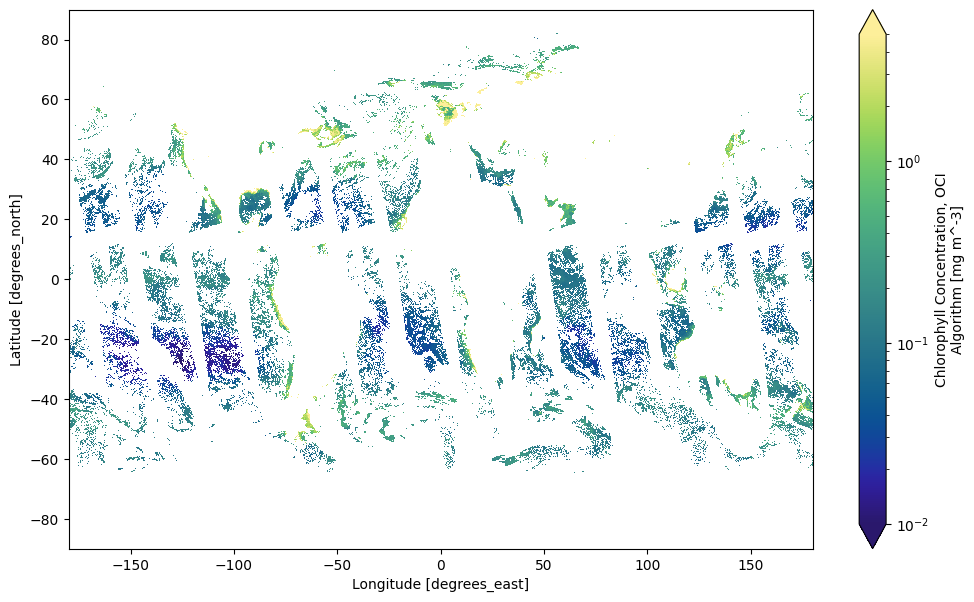

In [ ]:
fig, ax = plt.subplots(figsize=(12,7))
dataset["chlor_a"].sel({"date": 0}).plot(cmap=cmocean.cm.haline, norm=LogNorm(vmin=.01, vmax=5))
plt.show()

... to a map of average values, skipping "NaN" values that result from clouds.

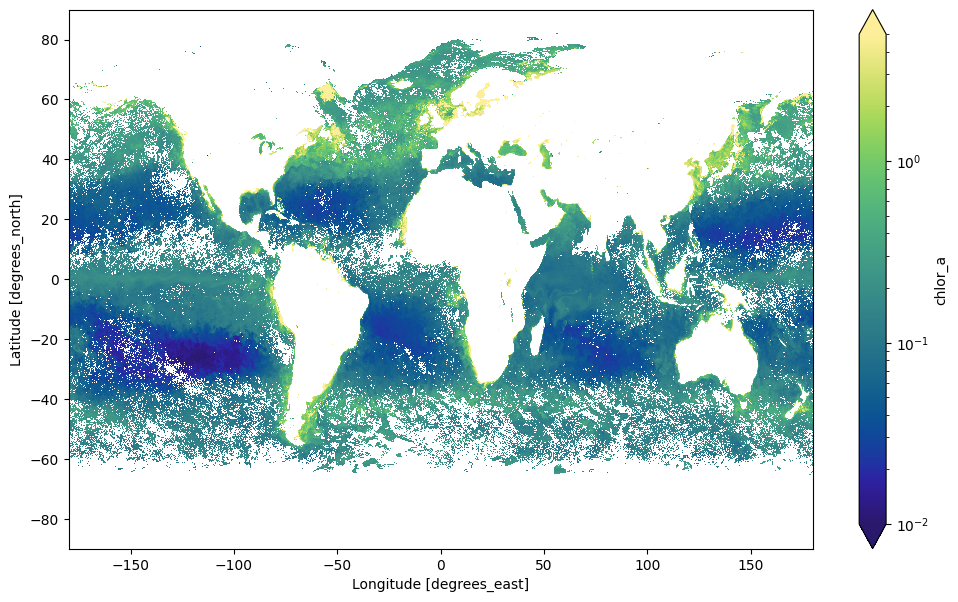

In [ ]:
fig, ax = plt.subplots(figsize=(12,7))
dataset["chlor_a"].mean("date").plot(cmap=cmocean.cm.haline, norm=LogNorm(vmin=.01, vmax=5))
plt.show()

That projection is atrocious so let's make it better even though this may take a minute.

/usr/local/lib/python3.11/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_physical/ne_10m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


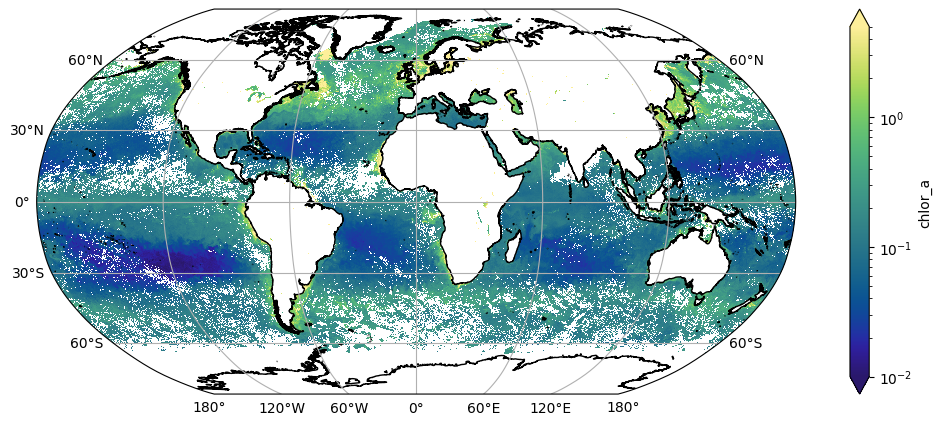

In [ ]:
fig, ax = plt.subplots(figsize=(14,5), subplot_kw=dict(projection=ccrs.Robinson()))
ax.coastlines(resolution='10m')
# ax.set_ylim(34,45)
# ax.set_xlim(-80,-60)

dataset["chlor_a"].mean("date").plot(ax=ax, cmap=cmocean.cm.haline, norm=LogNorm(vmin=.01, vmax=5),  transform=ccrs.PlateCarree())

# dataset["chlor_a"].mean("date").plot(ax=ax, x='lon', y='lat', cmap=distincti_cmap, transform=crs.PlateCarree())

gl = ax.gridlines(draw_labels=True)
gl.top_labels = False
gl.right_labels = False


plt.show()

In [ ]:
dataset

<xarray.Dataset> Size: 337MB
Dimensions:  (date: 13, lat: 1800, lon: 3600, rgb: 3, eightbitcolor: 256)
Coordinates:
  * lat      (lat) float32 7kB 89.95 89.85 89.75 89.65 ... -89.75 -89.85 -89.95
  * lon      (lon) float32 14kB -179.9 -179.9 -179.8 ... 179.8 179.9 180.0
Dimensions without coordinates: date, rgb, eightbitcolor
Data variables:
    chlor_a  (date, lat, lon) float32 337MB dask.array<chunksize=(1, 512, 1024), meta=np.ndarray>
    palette  (date, rgb, eightbitcolor) uint8 10kB dask.array<chunksize=(1, 3, 256), meta=np.ndarray>
Attributes: (12/64)
    product_name:                      PACE_OCI.20250412.L3m.DAY.CHL.V3_0.chl...
    instrument:                        OCI
    title:                             OCI Level-3 Standard Mapped Image
    project:                           Ocean Biology Processing Group (NASA/G...
    platform:                          PACE
    source:                            satellite observations from OCI-PACE
    ...                                ...
    identifier_product_doi:            10.5067/PACE/OCI/L3M/CHL/3.0
    keywords:                          Earth Science > Oceans > Ocean Chemist...
    keywords_vocabulary:               NASA Global Change Master Directory (G...
    data_bins:                         577095
    data_minimum:                      0.00551281
    data_maximum:                      91.690926

In [ ]:
dataset.sel(lat=37, lon=-74, method='nearest').chlor_a.values

array([       nan,        nan,        nan,        nan, 0.50203395,
       0.52009493, 0.48463616,        nan,        nan,        nan,
              nan,        nan, 0.53353184], dtype=float32)

In [ ]:
dataset.sel(lat=slice(37.3,37), lon=slice(-74, -73.8)).chlor_a.values.shape

(13, 3, 2)

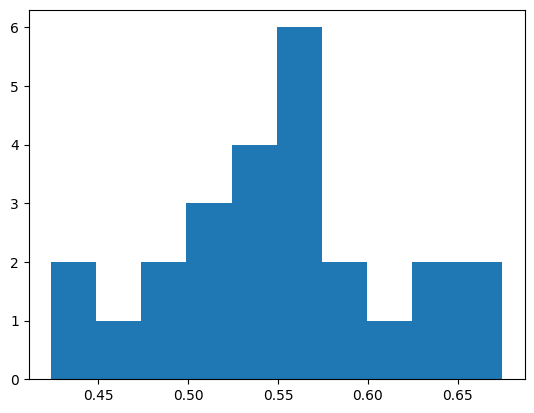

In [ ]:
plt.hist(dataset.sel(lat=slice(37.3,37), lon=slice(-74, -73.8)).chlor_a.values.flatten())
plt.show()

## 6. Download Data

Let's go ahead and download a couple granules.

Let's look at the `earthaccess.download` function, which is used
to copy files onto a filesystem local to the machine executing the
code. For this function, provide the output of
`earthaccess.search_data` along with a directory where `earthaccess` will store downloaded granules.

Even if you only want to read a slice of the data, and downloading
seems unncessary, if you use `earthaccess.open` while not running on a remote host with direct access to the NASA Earthdata Cloud,
performance will be very poor. This is not a problem with "the
cloud" or with `earthaccess`, it has to do with the data format and may soon be resolved.


In [ ]:
tspan = ("2025-03-01", "2025-05-30")
bbox = (-71.5, 43, -65, 48)
clouds = (0, 60)

results = earthaccess.search_data(
    short_name="PACE_OCI_L2_BGC_NRT",
    temporal=tspan,
    bounding_box=bbox,
    cloud_cover=clouds,
)

The `paths` list now contains paths to actual files on the local
filesystem.

In [ ]:
# paths = earthaccess.download(results, local_path="data")
# paths

We can open up that locally saved file using `xarray` as well.

In [ ]:
# open_datatree(paths[0])

[back to top](#Contents)

# Now let's look at some spectra

In [ ]:
tspan = ("2025-03-01", "2025-05-30")
bbox = (-71.5, 43, -65, 48)
clouds = (0, 60)


results = earthaccess.search_data(
    short_name="PACE_OCI_L2_AOP",
    temporal=tspan,
    bounding_box=bbox,
    cloud_cover=clouds,
)

paths = earthaccess.open(results)

In [ ]:
datatree = open_datatree(paths[2])
datatree

dataset = xr.merge(datatree.to_dict().values())
dataset
dataset = dataset.set_coords(("longitude", "latitude"))
dataset

In [ ]:
plt.hist(dataset["avw"].values.flatten(), range=[350,700], bins=30)
plt.show()

In [ ]:
fig = plt.figure(figsize=(18,7))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines(draw_labels={"left": "y", "bottom": "x"})
plot = dataset["avw"].plot(x="longitude", y="latitude", cmap=cmocean.cm.haline, ax=ax, vmin=430, vmax=550)

# ax.set_xlim(-66,-50)
# ax.set_ylim(-45,-32)

# plt.savefig('figs/cocco_chla.png',dpi=300,transparent=True)

Now we often want to grab a specific pixel and inspect the spectra and other attributes

In [ ]:
# I want to find the speed at a certain lat/lon point.
lat = 37
lon = -74

# First, find the index of the grid point nearest a specific lat/lon.
abslat = np.abs(dataset.latitude-lat)
abslon = np.abs(dataset.longitude-lon)
c = np.maximum(abslon, abslat)

([xloc], [yloc]) = np.where(c == np.min(c))

In [ ]:
# Now I can use that index location to get the values at the x/y diminsion
point_ds = dataset.sel(pixels_per_line=xloc, number_of_lines=yloc)

In [ ]:
fig, ax = plt.subplots(figsize=(12,7))

plt.plot(point_ds.wavelength_3d,point_ds["Rrs"].values.reshape(-1,172).T)
plt.axhline(0,ls='--')

plt.show()

Or we can mask out a specific section for analysis

In [ ]:
min_lon = -75
min_lat = 36
max_lon = -72
max_lat = 37

mask_lon = (dataset.longitude >= min_lon) & (dataset.longitude <= max_lon)
mask_lat = (dataset.latitude >= min_lat) & (dataset.latitude <= max_lat)
dataset = dataset.where(mask_lon & mask_lat,drop=True)

KeyboardInterrupt: 

In [ ]:
fig, ax = plt.subplots(figsize=(12,7))

plt.plot(dataset.wavelength_3d,dataset["Rrs"].values.reshape(-1,172)[::500].T)
plt.axhline(0,ls='--')

plt.show()

In [ ]:
fig = plt.figure(figsize=(18,7))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines(draw_labels={"left": "y", "bottom": "x"})
plot = dataset["avw"].plot(x="longitude", y="latitude", cmap=cmocean.cm.haline, ax=ax, vmin=430, vmax=550)

# ax.set_xlim(-66,-50)
# ax.set_ylim(-45,-32)